In [1]:
%load_ext jupyter_black
import torch
import numpy as np
from numba import cuda, float32, int32
import cuda_pricing as cp
from torch_pricing import asian_option, vmap_asian_option
import math
import matplotlib.pyplot as plt
import scienceplots
import tqdm

plt.style.use(["grid", "science", "no-latex"])

with open("../data/X_valid.npy", "rb") as f:
    X_valid = np.load(f)

We will use the pytorch implementation as a benchmark.

### Monte Carlo estimation using numba.cuda.reduce :

In [2]:
S = 50
I = 60
t = 0.2
ttm = 1
r = 0.1
sigma = 0.2
n_steps = 100
n_paths = 1000000

In [3]:
cuda_mean, cuda_var = cp.asian_option_1(S, I, n_paths, n_steps, t, ttm, r, sigma)
torch_mean = asian_option(
    n_paths, n_steps, S, I, t, torch.sqrt(torch.tensor(ttm / n_steps)), r, sigma
).mean()

/users/eleves-a/2020/saad.souilmi/Cuda-Project/venv/lib64/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/users/eleves-a/2020/saad.souilmi/Cuda-Project/venv/lib64/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [4]:
# Sanity Check
print(
    f"Cuda estimate = {cuda_mean} with confidence interval [{cuda_mean - 1.96*np.sqrt(cuda_var / n_paths)}, {cuda_mean + 1.96*np.sqrt(cuda_var / n_paths)}]. Benchmark value : {torch_mean.item()}"
)

Cuda estimate = 3.16599775 with confidence interval [3.1569122693647853, 3.1750832306352144]. Benchmark value : 3.1665968894958496


In [5]:
%%timeit
cuda_mean, cuda_var = cp.asian_option_1(S, I, n_paths, n_steps, t, ttm, r, sigma)
cuda.synchronize()

134 ms ± 506 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Monte Carlo estimation without numba.cuda.reduce : 

In [6]:
cuda_mean, cuda_var = cp.asian_option_2(S, I, n_paths, n_steps, t, ttm, r, sigma)

In [7]:
# Sanity check
print(
    f"Cuda estimate = {cuda_mean} with confidence interval [{cuda_mean - 1.96*np.sqrt(cuda_var / n_paths)}, {cuda_mean + 1.96*np.sqrt(cuda_var / n_paths)}]. Benchmark value : {torch_mean.item()}"
)

Cuda estimate = 3.1673836708068848 with confidence interval [3.158297077492536, 3.1764702641212335]. Benchmark value : 3.1665968894958496


In [8]:
%%timeit
cuda_mean, cuda_var = cp.asian_option_2(S, I, n_paths, n_steps, t, ttm, r, sigma)
cuda.synchronize()

132 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Parallelizing over Initial conditions :

In [9]:
torch.cuda.empty_cache()
param_grid = np.concatenate(
    (
        X_valid[:1000, 0].reshape(-1, 1),
        X_valid[:1000, 1].reshape(-1, 1),
        X_valid[:1000, 2].reshape(-1, 1),
        ttm * np.ones((1000, 1)),
        r * np.ones((1000, 1)),
        sigma * np.ones((1000, 1)),
    ),
    axis=1,
)
torch_param_grid = torch.tensor(param_grid).to("cuda")
torch_param_grid[:, 3] = torch.sqrt(torch_param_grid[:, 3] / n_steps)
torch_loader = torch.utils.data.DataLoader(torch_param_grid, batch_size=5)

In [10]:
# Every block samples n_paths for a different (t, S_t, I_t)
Y_cuda = cp.asian_option_4(
    np.ascontiguousarray(param_grid[:, 0]),
    np.ascontiguousarray(param_grid[:, 1]),
    n_paths,
    n_steps,
    np.ascontiguousarray(param_grid[:, 2]),
    ttm,
    r,
    sigma,
)

In [11]:
Y_torch = []
with tqdm.tqdm(
    total=len(torch_loader), desc="Generating data using torch", position=0, leave=True
) as progress_bar:
    for sample in torch_loader:
        sample_payoffs = vmap_asian_option(
            n_paths,
            n_steps,
            sample[:, 0],
            sample[:, 1],
            sample[:, 2],
            sample[:, 3],
            sample[:, 4],
            sample[:, 5],
        ).mean(axis=1)
        sample_payoffs = sample_payoffs.to("cpu")
        Y_torch.append(sample_payoffs)
        progress_bar.update(1)

Generating data using torch: 100%|██████████| 200/200 [01:01<00:00,  3.26it/s]


In [12]:
Y_torch = torch.cat(list(Y_torch), dim=0).numpy()

In [13]:
residuals = Y_cuda[:, 0] - Y_torch

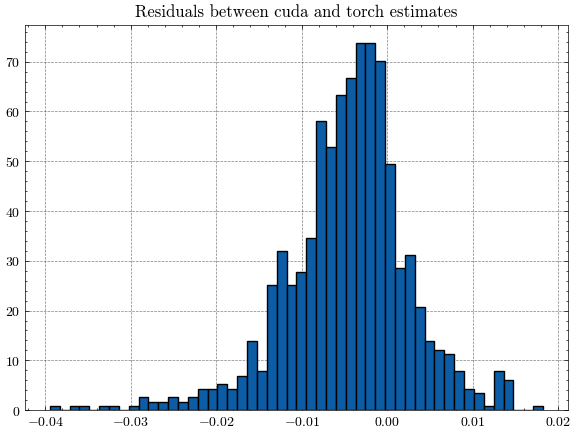

In [14]:
# Sanity check
fig = plt.figure(figsize=(7, 5))
plt.hist(residuals, bins=50, density=True, edgecolor="k")
plt.title("Residuals between cuda and torch estimates")
plt.show()
plt.close()

In [15]:
%%timeit
Y_cuda = cp.asian_option_4(
    np.ascontiguousarray(param_grid[:, 0]),
    np.ascontiguousarray(param_grid[:, 1]),
    n_paths,
    n_steps,
    np.ascontiguousarray(param_grid[:, 2]),
    ttm,
    r,
    sigma,
)
cuda.synchronize()

7.92 s ± 30.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# Every thread samples n_paths for a different (t, S_t, I_t)
Y_cuda = cp.asian_option_3(
    np.ascontiguousarray(param_grid[:, 0]),
    np.ascontiguousarray(param_grid[:, 1]),
    n_paths,
    n_steps,
    np.ascontiguousarray(param_grid[:, 2]),
    ttm,
    r,
    sigma,
)

/users/eleves-a/2020/saad.souilmi/Cuda-Project/venv/lib64/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


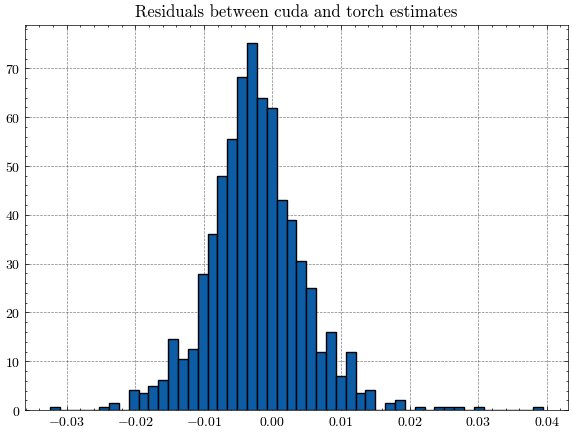

In [17]:
# Sanity check
residuals = Y_cuda[:, 0] - Y_torch
fig = plt.figure(figsize=(7, 5))
plt.hist(residuals, bins=50, density=True, edgecolor="k")
plt.title("Residuals between cuda and torch estimates")
plt.show()
plt.close()

In [18]:
%%timeit
Y_cuda = cp.asian_option_3(
    np.ascontiguousarray(param_grid[:, 0]),
    np.ascontiguousarray(param_grid[:, 1]),
    n_paths,
    n_steps,
    np.ascontiguousarray(param_grid[:, 2]),
    ttm,
    r,
    sigma,
)
cuda.synchronize()

5min 51s ± 373 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
